In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as cm
import datetime
from datetime import timedelta
from epiweeks import Week, Year
import epiweeks as epi
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
import statsmodels.nonparametric.smoothers_lowess as lowess
from pandas.plotting import lag_plot
from sklearn.linear_model import LinearRegression

import glob
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
def conv_epiweek(x):
    week=Week.fromdate(pd.to_datetime(x))
    return str(week.year)+'EW'+'{:02}'.format(week.week)

def conv_epiweek_stdate(dt):
    conv_dt=pd.to_datetime(epi.Week.fromdate(pd.to_datetime(dt)).startdate().strftime('%Y-%m-%d'))
    return conv_dt

def get_LinReg(y,x):
    model=LinearRegression()
    model.fit(x.reshape(-1,1), y.reshape(-1,1))
    yp=model.predict(x.reshape(-1,1))
    return yp

def get_index_days(ind,win):
    x=[(ind[i]-ind[0]).days for i in range(0,win)]
    return np.array(x).reshape(-1,1)

def get_rolling_LinReg(df,smooth='',win=3,v=False):
    if smooth:
        col='log_viral_load'+'_'+smooth
        col_out='_smooth'
    else:
        col='log_viral_load'
        col_out=''
    tempdf=df.copy()
    tot_len=tempdf.shape[0]
    win=win
    rolling_range=tot_len-win+1
    lindf=pd.DataFrame(index=tempdf.sample_collect_date,columns=tempdf.sample_collect_date)
    for i in range(0,rolling_range):
        try:
            yy=tempdf.iloc[i:i+win]
            yy=yy.reset_index(drop=True)
            x=get_index_days(yy.sample_collect_date,win)
            y=yy[col].values.reshape(-1,1)
            yp=(get_LinReg(y,x))
            lindf.loc[yy.sample_collect_date,yy.sample_collect_date[win-1]]=yp[:,0]
            slope=(yp[-1]-yp[0])/(x[-1]-x[0]+1)
            temp_ind=tempdf[tempdf.sample_collect_date==yy.sample_collect_date[win-1]].index
            tempdf.loc[temp_ind,'slope'+col_out]=slope
            tempdf.loc[temp_ind,'pct_daily_change'+col_out]=((10**slope)-1)*100            
        except Exception as e:
            if v:
                print(e)
            continue
    return tempdf,lindf

In [3]:
ssh_df=pd.read_csv('/project/biocomplexity/COVID-19_commons/data/VDH_wastewater/county_mappings/ssh_name_mapping.csv')
ssh_map=dict(zip(ssh_df['new_file_name'],ssh_df['dashboard_name']))

In [6]:
df=pd.read_csv('/project/biocomplexity/COVID-19_commons_tmp//data/opioids_url/Sewershed_PCR_Conc.csv',date_parser=True)
df.sample_collect_date=pd.to_datetime(df.sample_collect_date)
df.test_result_date=pd.to_datetime(df.test_result_date)
df.loc[:,'EW']=df.sample_collect_date.apply(lambda x: conv_epiweek(x))
df.loc[:,'EW_stdate']=df.sample_collect_date.apply(lambda x: conv_epiweek_stdate(x))
temp=df.groupby(['sewershed','EW','EW_stdate']).size().reset_index().rename(columns={0:'no_of_samples'})
df=df.merge(temp)

In [7]:
df.EW_stdate.max()

Timestamp('2023-10-08 00:00:00')

In [8]:
df.loc[:,'sewershed']=df.sewershed.replace(ssh_map)

In [9]:
len(df[df.sample_collect_date>='2022-09-01'].sewershed.unique())

36

Text(0.5, 1.0, 'Number of sites reporting twice weekly')

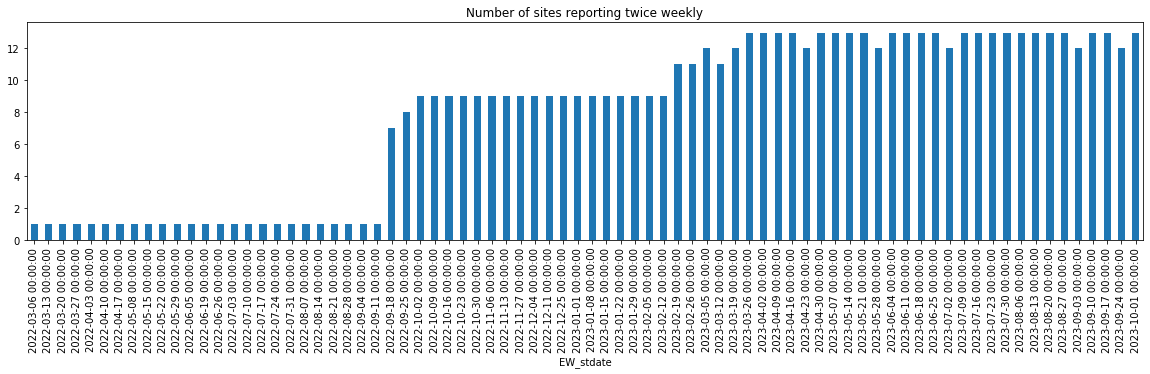

In [10]:
ax=temp[(temp.no_of_samples==2)].groupby(['EW_stdate']).size().plot.bar(figsize=(20, 4))
ax.set_title('Number of sites reporting twice weekly')
# plt.savefig('plots/twice_weekly_sites.pdf',bbox_inches='tight')

In [11]:
ddf=df[df.no_of_samples==2]
temp1=ddf.groupby(['EW','wwtp_name','sewershed','EW_stdate'])['sample_collect_date'].agg([min]).reset_index().rename(columns={'min':'sample_collect_date'})
temp1.loc[:,'test']='test1'
temp2=ddf.groupby(['EW','wwtp_name','sewershed','EW_stdate'])['sample_collect_date'].agg([max]).reset_index().rename(columns={'max':'sample_collect_date'})
temp2.loc[:,'test']='test2'
temp1=temp1.append(temp2)

ddf=ddf.merge(temp1)
temp3=ddf.groupby(['EW','wwtp_name','sewershed','EW_stdate']).mean().reset_index()
temp3.loc[:,'test']='mean_test'
temp3.loc[:,'sample_collect_date']=temp3.loc[:,'EW_stdate']
ddf=ddf.append(temp3)

In [12]:
one_samp_ss=set(df[(df.sample_collect_date>='2022-09-01')&(df.no_of_samples==1)].sewershed.unique())
two_samp_ss=set(df[(df.sample_collect_date>='2022-09-01')&(df.no_of_samples==2)].sewershed.unique())
only_one_samp=list(one_samp_ss-two_samp_ss)

In [13]:
sdf=df[df.sewershed.isin(only_one_samp)]
sdf.loc[:,'test']='one_test'
alldf=sdf.append(ddf)

/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [14]:
alldf.test.unique()

array(['one_test', 'test1', 'test2', 'mean_test'], dtype=object)

In [23]:
alldf.EW_stdate.max()

Timestamp('2023-10-08 00:00:00')

In [15]:
# alldf[alldf.test=='mean_test']

In [16]:
# _,ax=plt.subplots(figsize=(14,5))
# l='MooresCreek'
# color=['bo','rd']
# i=0
# for tt in ['test1','test2','test_mean']:
#     cols=['sample_collect_date',]
#     locdf=ddf[(ddf.sewershed==l)&(ddf.test==tt)]
#     locdf=locdf.set_index('sample_collect_date')
#     locdf=locdf.sort_index()
#     ax.plot(locdf.index,np.log(locdf['viral_load']))
#     i+=1
# ax.legend()

In [17]:
alldf.loc[:,'log_viral_load']=np.log10(alldf['viral_load'])

/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [18]:
alldf.to_csv('output/sewershed_test_types.csv',index=None)

In [19]:
predf=alldf[alldf.EW_stdate<'2022-09-18']
pre_two_locs=predf.sewershed.unique()
for win in [3,5]:
    for l in pre_two_locs:
        if win==3:
            trend='ST'
        elif win==5:
            trend='LT'
        tempdf=predf[(predf.sewershed==l)][['sample_collect_date','viral_load','log_viral_load']]
        tempdf=tempdf.sort_values(by='sample_collect_date')
        tempdf.loc[tempdf.viral_load==0,'viral_load']=np.nan
        tempdf.viral_load=tempdf.viral_load.ffill()
        tempdf.loc[:,'log_viral_load']=np.log10(tempdf['viral_load'])
        tempdf.loc[:,'log_viral_load_smooth']=tempdf['log_viral_load'].rolling(7).mean()
        tempdf1,lindf1=get_rolling_LinReg(tempdf,smooth='',win=win)
        tempdf1.loc[:,'sewershed']=l
        tempdf2,lindf2=get_rolling_LinReg(tempdf,smooth='smooth',win=win)
        tempdf2.loc[:,'sewershed']=l
        bothdf=tempdf1.merge(tempdf2)
        bothdf.to_csv('output/slope_pct_v2/{}_pre_two_tests_{}.csv'.format(l,trend),index=None)
        lindf1.to_csv('output/lin_reg_v2/{}_pre_two_tests_{}.csv'.format(l,trend))
        lindf2.to_csv('output/lin_reg_v2/{}_pre_two_tests_{}_smooth.csv'.format(l,trend))
        print(l)

Virginia Initiative Plant
Nansemond
HL Mooney
Onancock
Richmond
Upper Occoquan
Williamsburg
Pound
Aquia
Little Falls Run
Wolf Creek
HRSD_ATCE
Tazewell_T
Lebanon
Hillsville
Clintwood
Parkins Mill
Virginia Initiative Plant
Nansemond
HL Mooney
Onancock
Richmond
Upper Occoquan
Williamsburg
Pound
Aquia
Little Falls Run
Wolf Creek
HRSD_ATCE
Tazewell_T
Lebanon
Hillsville
Clintwood
Parkins Mill


In [20]:
two_locs=alldf[alldf.test.isin(['test1','test2','mean_test'])].sewershed.unique()
for win in [3,5]:
    for l in two_locs:
        if win==3:
            trend='ST'
        elif win==5:
            trend='LT'
        tempdf=alldf[(alldf.sewershed==l)][['sample_collect_date','viral_load','log_viral_load']]
        tempdf=tempdf.sort_values(by='sample_collect_date')
        tempdf.loc[tempdf.viral_load==0,'viral_load']=np.nan
        tempdf.viral_load=tempdf.viral_load.ffill()
        tempdf.loc[:,'log_viral_load']=np.log10(tempdf['viral_load'])
        tempdf.loc[:,'log_viral_load_smooth']=tempdf['log_viral_load'].rolling(7).mean()
        tempdf1,lindf1=get_rolling_LinReg(tempdf,smooth='',win=win)
        tempdf1.loc[:,'sewershed']=l
        tempdf2,lindf2=get_rolling_LinReg(tempdf,smooth='smooth',win=win)
        tempdf2.loc[:,'sewershed']=l
        bothdf=tempdf1.merge(tempdf2)
        bothdf.to_csv('output/slope_pct_v2/{}_two_tests_{}.csv'.format(l,trend),index=None)
        lindf1.to_csv('output/lin_reg_v2/{}_two_tests_{}.csv'.format(l,trend))
        lindf2.to_csv('output/lin_reg_v2/{}_two_tests_{}_smooth.csv'.format(l,trend))
        print(l)

Parkins Mill
Alexandria Renew
North River
Blacksburg
Pepper's Ferry
Roanoke
Coeburn Norton Wise
Moores Creek
Lynchburg
LowerJ_T
LowMoor_T
RockyMount
Arlington_T
Parkins Mill
Alexandria Renew
North River
Blacksburg
Pepper's Ferry
Roanoke
Coeburn Norton Wise
Moores Creek
Lynchburg
LowerJ_T
LowMoor_T
RockyMount
Arlington_T


In [21]:
bothdf

,sample_collect_date,viral_load,log_viral_load,log_viral_load_smooth,slope,pct_daily_change,sewershed,slope_smooth,pct_daily_change_smooth
0,2023-03-26,1.164000e+12,12.065953,NaN,NaN,NaN,Arlington_T,NaN,NaN
1,2023-03-27,1.540000e+12,12.187521,NaN,NaN,NaN,Arlington_T,NaN,NaN
2,2023-03-29,7.880000e+11,11.896526,NaN,NaN,NaN,Arlington_T,NaN,NaN
3,2023-04-02,1.013500e+12,12.005824,NaN,NaN,NaN,Arlington_T,NaN,NaN
4,2023-04-03,4.670000e+11,11.669317,NaN,NaN,NaN,Arlington_T,NaN,NaN
...,...,...,...,...,...,...,...,...,...
79,2023-09-25,4.550000e+11,11.658011,11.838013,-0.018000,-4.059921,Arlington_T,-0.007679,-1.752597
80,2023-09-27,1.100000e+12,12.041393,11.885945,0.001215,0.280050,Arlington_T,-0.001353,-0.310987
81,2023-10-01,7.335000e+11,11.865400,11.883094,-0.001823,-0.418950,Arlington_T,0.003185,0.736040
82,2023-10-02,1.100000e+12,12.041393,11.901851,0.018949,4.459698,Arlington_T,0.005150,1.192957


In [49]:
one_locs=alldf[alldf.test.isin(['one_test'])].sewershed.unique()
for win in [3,5]:
    for l in one_locs:
        if win==3:
            trend='ST'
        elif win==5:
            trend='LT'
        tempdf=alldf[(alldf.sewershed==l)][['sample_collect_date','viral_load']]
        tempdf=tempdf.sort_values(by='sample_collect_date')
        tempdf.loc[tempdf.viral_load==0,'viral_load']=np.nan
        tempdf.viral_load=tempdf.viral_load.ffill()
        tempdf.loc[:,'log_viral_load']=np.log10(tempdf['viral_load'])
        tempdf.loc[:,'log_viral_load_smooth']=tempdf['log_viral_load'].rolling(7).mean()
        tempdf1,lindf1=get_rolling_LinReg(tempdf,smooth='',win=win)
        tempdf1.loc[:,'sewershed']=l
        tempdf2,lindf2=get_rolling_LinReg(tempdf,smooth='smooth',win=win)
        tempdf2.loc[:,'sewershed']=l
        bothdf=tempdf1.merge(tempdf2)
        bothdf.to_csv('output/slope_pct_v2/{}_one_tests_{}.csv'.format(l,trend),index=None)
        lindf1.to_csv('output/lin_reg_v2/{}_one_tests_{}.csv'.format(l,trend)) 
        lindf2.to_csv('output/lin_reg_v2/{}_one_tests_{}_smooth.csv'.format(l,trend))
        print(l)

Virginia Initiative Plant
Nansemond
HL Mooney
Onancock
Richmond
Upper Occoquan
Williamsburg
Pound
Aquia
Little Falls Run
Wolf Creek
HRSD_ATCE
Tazewell_T
Lebanon
Hillsville
Clintwood
Henrico
Loudoun
HRSD_AB
HRSD_BH
HRSD_JR
HRSD_YR
Halifax_T
Virginia Initiative Plant
Nansemond
HL Mooney
Onancock
Richmond
Upper Occoquan
Williamsburg
Pound
Aquia
Little Falls Run
Wolf Creek
HRSD_ATCE
Tazewell_T
Lebanon
Hillsville
Clintwood
Henrico
Loudoun
HRSD_AB
HRSD_BH
HRSD_JR
HRSD_YR
Halifax_T


In [29]:
predf=alldf[alldf.EW_stdate<'2022-09-18']
pre_two_locs=predf.sewershed.unique()
tts='pre_two_tests'
samp='one_tests'
for win in [3,5]:
    for l in pre_two_locs:
        if win==3:
            trend='ST'
        elif win==5:
            trend='LT'
        tempdf=predf[(predf.sewershed==l)][['sample_collect_date','viral_load','log_viral_load']]
        tempdf=tempdf.sort_values(by='sample_collect_date')
        tempdf.loc[tempdf.viral_load==0,'viral_load']=np.nan
        tempdf.viral_load=tempdf.viral_load.ffill()
        tempdf.loc[:,'log_viral_load']=np.log10(tempdf['viral_load'])
        tempdf.loc[:,'log_viral_load_smooth']=tempdf['log_viral_load'].rolling(7).mean()
        tempdf1,lindf1=get_rolling_LinReg(tempdf,smooth='',win=win)
        tempdf1.loc[:,'sewershed']=l
        tempdf2,lindf2=get_rolling_LinReg(tempdf,smooth='smooth',win=win)
        tempdf2.loc[:,'sewershed']=l
        bothdf=tempdf1.merge(tempdf2)
        bothdf.to_csv('output/slope_pct_v2/{}_{}_{}_{}.csv'.format(l,tts,samp,trend),index=None)
        lindf1.to_csv('output/lin_reg_v2//{}_{}_{}_{}.csv'.format(l,tts,samp,trend)) 
        lindf2.to_csv('output/lin_reg_v2//{}_{}_{}_{}_smooth.csv'.format(l,tts,samp,trend))
        print(l)

Virginia Initiative Plant
Nansemond
HL Mooney
Onancock
Richmond
Upper Occoquan
Williamsburg
Pound
Aquia
Little Falls Run
Wolf Creek
HRSD_ATCE
Tazewell_T
Lebanon
Hillsville
Clintwood
Parkins Mill
Virginia Initiative Plant
Nansemond
HL Mooney
Onancock
Richmond
Upper Occoquan
Williamsburg
Pound
Aquia
Little Falls Run
Wolf Creek
HRSD_ATCE
Tazewell_T
Lebanon
Hillsville
Clintwood
Parkins Mill


In [54]:
for tts in ['test1','test2','mean_test','one_test']:
    if (tts=='test1') or (tts=='test2') or (tts=='mean_test'):
        samp='two_tests'
    elif tts=='one_test':
        samp='one_tests'
    stdf=alldf[alldf.test==tts]
    slocs=stdf.sewershed.unique()
    for win in [3,5]:
        for l in slocs:
            if win==3:
                trend='ST'
            elif win==5:
                trend='LT'
            tempdf=stdf[(stdf.sewershed==l)][['sample_collect_date','viral_load']]
            tempdf=tempdf.sort_values(by='sample_collect_date')
            tempdf.loc[tempdf.viral_load==0,'viral_load']=np.nan
            tempdf.viral_load=tempdf.viral_load.ffill()
            tempdf.loc[:,'log_viral_load']=np.log10(tempdf['viral_load'])
            tempdf.loc[:,'log_viral_load_smooth']=tempdf['log_viral_load'].rolling(7).mean()
            tempdf1,lindf1=get_rolling_LinReg(tempdf,smooth='',win=win,v=True)
            tempdf1.loc[:,'sewershed']=l
            tempdf2,lindf2=get_rolling_LinReg(tempdf,smooth='smooth',win=win,v=True)
            tempdf2.loc[:,'sewershed']=l
            bothdf=tempdf1.merge(tempdf2)
            bothdf.to_csv('output/slope_pct_v2/{}_{}_{}_{}.csv'.format(l,tts,samp,trend),index=None)
            lindf1.to_csv('output/lin_reg_v2//{}_{}_{}_{}.csv'.format(l,tts,samp,trend)) 
            lindf2.to_csv('output/lin_reg_v2//{}_{}_{}_{}_smooth.csv'.format(l,tts,samp,trend))
            print(l,samp,trend)

Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Parkins Mill two_tests ST
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Alexandria Renew two_tests ST
Input contains NaN, infinity or a value too large for dtype('float64').
Input co

In [234]:
temp1=tempdf.copy()

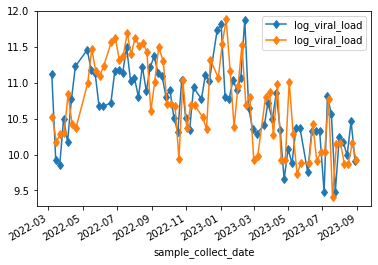

In [239]:
ax=temp1.plot(x='sample_collect_date',y='log_viral_load',marker='d')
tempdf.plot(x='sample_collect_date',y='log_viral_load',ax=ax,marker='d')

,sample_collect_date,viral_load,log_viral_load,log_viral_load_smooth
1,2022-03-08,3.380000e+10,10.528917,NaN
3,2022-03-15,1.510000e+10,10.178977,NaN
5,2022-03-22,1.930000e+10,10.285557,NaN
7,2022-03-29,2.010000e+10,10.303196,NaN
9,2022-04-05,6.890000e+10,10.838219,NaN
...,...,...,...,...
857,2023-08-02,1.450000e+10,10.161368,10.065260
877,2023-08-09,7.480000e+09,9.873902,10.060090
897,2023-08-16,7.400000e+09,9.869232,10.037211
917,2023-08-23,1.440000e+10,10.158362,10.055637


In [187]:
tt=tt.asfreq('D')

In [211]:
ttf=tt.ffill()

In [214]:
tt

,log_viral_load
sample_collect_date,
2021-09-13,12.176091
2021-09-14,NaN
2021-09-15,NaN
2021-09-16,NaN
2021-09-17,NaN
...,...
2023-08-31,NaN
2023-09-01,NaN
2023-09-02,NaN


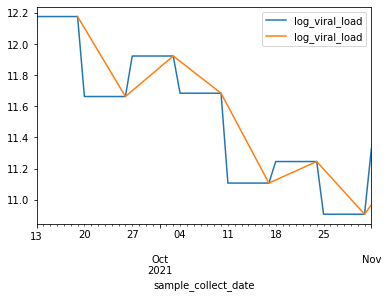

In [220]:
ax=ttf.iloc[:50].plot()
# tt.plot()
ttf.rolling(7).mean()[:50].plot(ax=ax)

(9, 12)

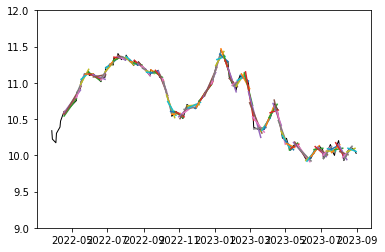

In [132]:
tr=12
ax=plt.plot(tempdf['sample_collect_date'],tempdf['log_viral_load_smooth'],color='k',linewidth=1)
# plt.scatter(tempdf['sample_collect_date'],tempdf['log_viral_load'])
for dt in lindf.columns[tr:]:    
    plt.plot(lindf.index[tr:],lindf.loc[lindf.index[tr:],dt])
plt.ylim([9,12])

In [170]:
sdf

,sample_id,wwtp_name,sewershed,population_served,sample_type,sample_matrix,sample_collect_date,sample_collect_time,flow_rate,test_result_date,pcr_target_avg_conc,pcr_target_below_lod,lod_sewage,rec_eff_percent,viral_load,EW,no_of_samples
0,DCLS_SMP_WW1_WK1,atlantic,HRSD_AT,343016,24-hr flow-weighted composite,raw wastewater,2021-09-13,09:22,28.1,2021-09-20,40000.0,False,1350,41.10,4.250000e+12,2021EW37,1
1,DCLS_SMP_WW2_WK1,HRSD: Virginia Initiative Plant,HRSD_VIP,192347,24-hr flow-weighted composite,raw wastewater,2021-09-13,11:12,23.7,2021-09-20,41875.0,False,1350,33.02,3.750000e+12,2021EW37,1
2,DCLS_SMP_WW3_WK1,Moores Creek Advanced Water Resource Rec,MooresCreek,118266,24-hr flow-weighted composite,post grit removal,2021-09-13,00:00,10.1,2021-09-20,12500.0,False,1350,14.39,4.780000e+11,2021EW37,1
3,DCLS_SMP_WW4_WK1,HRSD: Nansemond,HRSD_NA,197608,grab,raw wastewater,2021-09-14,12:14,15.3,2021-09-20,28750.0,False,1350,14.39,1.670000e+12,2021EW37,1
4,DCLS_SMP_WW5_WK1,City of Danville Northside Wastewater Tr,Danville,47000,24-hr flow-weighted composite,raw wastewater,2021-09-13,00:01,5.1,2021-09-20,9688.0,False,1350,36.02,1.860000e+11,2021EW37,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3176,DCLS_SMP_WW38_WK104,Town of Rocky Mount WWTP,RockyMount,5000,24-hr flow-weighted composite,post grit removal,2023-09-04,07:10,0.5,2023-09-07,3551.0,True,6200,0.57,6.710000e+09,2023EW36,1
3177,DCLS_SMP_WW42_WK104,HRSD: Army Base,HRSD_AB,78322,grab,raw wastewater,2023-09-05,09:18,11.3,2023-09-07,2287.0,True,6200,0.25,9.820000e+10,2023EW36,1
3178,DCLS_SMP_WW43_WK104,HRSD: Boat Harbor,HRSD_BH,118497,grab,raw wastewater,2023-09-05,09:18,10.8,2023-09-07,1326.0,True,6200,0.23,5.430000e+10,2023EW36,1
3179,DCLS_SMP_WW44_WK104,HRSD: James River,HRSD_JR,141543,grab,raw wastewater,2023-09-05,08:47,12.2,2023-09-07,10174.0,False,6200,1.52,4.710000e+11,2023EW36,1


In [33]:
test12_loc=alldf[alldf.test.isin(['test1','test2'])].sewershed.unique()
testm_loc=alldf[alldf.test.isin(['mean_test'])].sewershed.unique()

In [34]:
test12_loc

array(['Parkins Mill', 'Alexandria Renew', 'North River', 'Blacksburg',
       "Pepper's Ferry", 'Roanoke', 'Coeburn Norton Wise', 'Moores Creek',
       'Lynchburg', 'LowerJ_T', 'LowMoor_T', 'RockyMount', 'Arlington_T'],
      dtype=object)

In [38]:
test12_loc

array(['Parkins Mill', 'Alexandria Renew', 'North River', 'Blacksburg',
       "Pepper's Ferry", 'Roanoke', 'Coeburn Norton Wise', 'Moores Creek',
       'Lynchburg', 'LowerJ_T', 'LowMoor_T', 'RockyMount', 'Arlington_T'],
      dtype=object)

In [39]:
testm_loc

array(['Parkins Mill', 'Alexandria Renew', 'Blacksburg',
       'Coeburn Norton Wise', 'North River', "Pepper's Ferry", 'Roanoke',
       'Moores Creek', 'Lynchburg', 'LowMoor_T', 'LowerJ_T', 'RockyMount',
       'Arlington_T'], dtype=object)